In [1]:
%matplotlib inline

In [2]:
import cv2 as cv
print(cv.__version__)

3.4.3


In [3]:
from imgaug import augmenters as iaa
import imgaug as ia

In [4]:
# !pip install git+https://github.com/aleju/imgaug

In [5]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [6]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Scale((224, 224)),
            iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Affine(rotate=(-40, 40), mode='symmetric'),
            iaa.Sometimes(0.25,
                          iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                     iaa.CoarseDropout(0.1, size_percent=0.5)])),
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True),
            iaa.PiecewiseAffine(),            
        ])
      
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
#    'train': transforms.Compose([
#        transforms.RandomHorizontalFlip(),
#        transforms.RandomVerticalFlip(),
#        transforms.RandomRotation((-180,180)),
#        transforms.RandomAffine(degrees=(-30,30), shear=(-20,20)),
#        #transforms.Resize(256),
#        #transforms.CenterCrop(224),
#        transforms.RandomResizedCrop(224),
#        transforms.ToTensor(),
#        transforms.Normalize([0.5548, 0.4508, 0.3435], [0.2281, 0.2384, 0.2376])
#    ]),
    'train': transforms.Compose([
        ImgAugTransform(),
        lambda x: Image.fromarray(x),
        transforms.ToTensor(),
        transforms.Normalize([0.5548, 0.4508, 0.3435], [0.2281, 0.2384, 0.2376])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5604, 0.4540, 0.3481], [0.2260, 0.2367, 0.2352])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5604, 0.4540, 0.3481], [0.2260, 0.2367, 0.2352])
    ]),
    'test2': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5604, 0.4540, 0.3481], [0.2260, 0.2367, 0.2352])
    ]),
    'test2-aug1': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5604, 0.4540, 0.3481], [0.2260, 0.2367, 0.2352])
    ]),
    'test2-aug2': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5604, 0.4540, 0.3481], [0.2260, 0.2367, 0.2352])
    ]),
    'test2-aug3': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5604, 0.4540, 0.3481], [0.2260, 0.2367, 0.2352])
    ]),
}

data_dir = '../data/food/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test', 'test2', 'test2-aug1', 'test2-aug2', 'test2-aug3']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val', 'test', 'test2', 'test2-aug1', 'test2-aug2', 'test2-aug3']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test', 'test2', 'test2-aug1', 'test2-aug2', 'test2-aug3']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#device = torch.device("cpu")

cuda:0


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



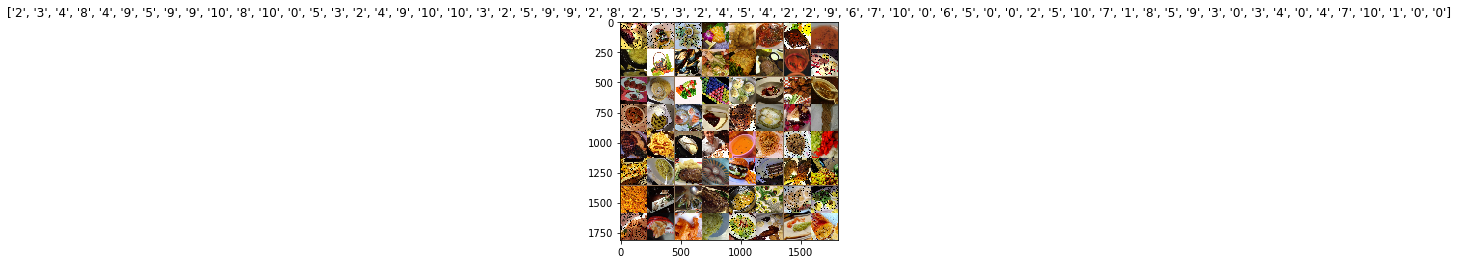

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5548, 0.4508, 0.3435])
    std = np.array([0.2281, 0.2384, 0.2376])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
classes = ('Bread', 'DairyProduct', 'Dessert', 'Egg', 'Friedfood',
    'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit')

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 11)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.5 every 10 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer_ft, mode='min', patience=6, verbose=True)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.5)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/dllab/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 52747756.09it/s]


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 1.5954 Acc: 0.4755
val Loss: 0.8229 Acc: 0.7528

Epoch 1/99
----------
train Loss: 0.9057 Acc: 0.7089
val Loss: 0.6104 Acc: 0.8085

Epoch 2/99
----------
train Loss: 0.7437 Acc: 0.7542
val Loss: 0.5270 Acc: 0.8324

Epoch 3/99
----------
train Loss: 0.6703 Acc: 0.7746
val Loss: 0.5298 Acc: 0.8245

Epoch 4/99
----------
train Loss: 0.6103 Acc: 0.7996
val Loss: 0.4775 Acc: 0.8478

Epoch 5/99
----------
train Loss: 0.5695 Acc: 0.8117
val Loss: 0.4478 Acc: 0.8580

Epoch 6/99
----------
train Loss: 0.5227 Acc: 0.8268
val Loss: 0.4419 Acc: 0.8569

Epoch 7/99
----------
train Loss: 0.5040 Acc: 0.8319
val Loss: 0.4235 Acc: 0.8673

Epoch 8/99
----------
train Loss: 0.4748 Acc: 0.8400
val Loss: 0.4062 Acc: 0.8729

Epoch 9/99
----------
train Loss: 0.4585 Acc: 0.8458
val Loss: 0.4103 Acc: 0.8714

Epoch 10/99
----------
train Loss: 0.4375 Acc: 0.8563
val Loss: 0.4184 Acc: 0.8671

Epoch 11/99
----------
train Loss: 0.4175 Acc: 0.8599
val Loss: 0.3874 Acc: 0.8708

Ep

train Loss: 0.1995 Acc: 0.9362
val Loss: 0.3383 Acc: 0.8924

Epoch 95/99
----------
train Loss: 0.2023 Acc: 0.9344
val Loss: 0.3368 Acc: 0.8910

Epoch 96/99
----------
train Loss: 0.2097 Acc: 0.9310
val Loss: 0.3438 Acc: 0.8907

Epoch 97/99
----------
train Loss: 0.2075 Acc: 0.9325
val Loss: 0.3351 Acc: 0.8924

Epoch 98/99
----------
train Loss: 0.2119 Acc: 0.9277
val Loss: 0.3433 Acc: 0.8918

Epoch 99/99
----------
train Loss: 0.2117 Acc: 0.9300
val Loss: 0.3363 Acc: 0.8927

Training complete in 337m 18s
Best val Acc: 0.895918


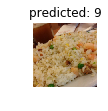

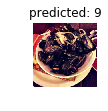

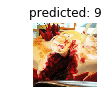

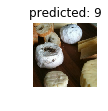

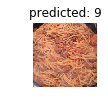

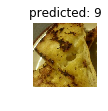

In [13]:
visualize_model(model_ft)

In [16]:
print('==> Saving model..')
#save entire model
model_name = './model-' + str(time.time()) + '.pt'
torch.save(model_ft, model_name)

print('Finished Saving')

==> Saving model..
Finished Saving


In [15]:
print('==> Loading model..')

#If you save the entire model
model_name = 'model-2-2-imgaug v1.pt'
model_ft = torch.load(model_name)

print('Finished Loading')

==> Loading model..
Finished Loading


In [16]:
######################
# Test the Model
######################
def test(t_data):
    print('test data set: %s' %(t_data))
          
    correct = 0
    total = 0
    running_loss = 0.0

    class_correct = list(0. for i in range(11))
    class_total = list(0. for i in range(11))

    with torch.no_grad():
        for data in dataloaders[t_data]:
            images, labels = data

            #if device == 'cuda':
            #    images = images.cuda(0)
            #    labels = labels.cuda(0)
            #else:
            #    images = images.cpu()
            #    labels = labels.cpu()
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_ft(images)
            _, predicted = torch.max(outputs, 1)
        
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            c = (predicted == labels).squeeze()
            #print(predicted)
            #print(labels.size(0))
            #print(c)
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print('Accuracy of the network on the %d test images: %.2f%%, and loss is: %.3f'
          % (total, 100 * correct / total, running_loss / total))

    for i in range(11):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [17]:
test('test')

test data set: test
Accuracy of the network on the 3347 test images: 90.80%, and loss is: 0.005
Accuracy of Bread : 86 %
Accuracy of DairyProduct : 79 %
Accuracy of Dessert : 95 %
Accuracy of   Egg : 87 %
Accuracy of Friedfood : 85 %
Accuracy of  Meat : 90 %
Accuracy of Noodles-Pasta : 90 %
Accuracy of  Rice : 96 %
Accuracy of Seafood : 97 %
Accuracy of  Soup : 94 %
Accuracy of Vegetable-Fruit : 97 %


In [18]:
test('test2')

test data set: test2
Accuracy of the network on the 838 test images: 90.45%, and loss is: 0.004
Accuracy of Bread : 85 %
Accuracy of DairyProduct : 78 %
Accuracy of Dessert : 98 %
Accuracy of   Egg : 85 %
Accuracy of Friedfood : 83 %
Accuracy of  Meat : 90 %
Accuracy of Noodles-Pasta : 89 %
Accuracy of  Rice : 94 %
Accuracy of Seafood : 100 %
Accuracy of  Soup : 96 %
Accuracy of Vegetable-Fruit : 97 %


In [19]:
test('test2-aug1')

test data set: test2-aug1
Accuracy of the network on the 838 test images: 88.54%, and loss is: 0.008
Accuracy of Bread : 83 %
Accuracy of DairyProduct : 83 %
Accuracy of Dessert : 100 %
Accuracy of   Egg : 76 %
Accuracy of Friedfood : 78 %
Accuracy of  Meat : 93 %
Accuracy of Noodles-Pasta : 89 %
Accuracy of  Rice : 97 %
Accuracy of Seafood : 95 %
Accuracy of  Soup : 93 %
Accuracy of Vegetable-Fruit : 96 %


In [20]:
test('test2-aug2')

test data set: test2-aug2
Accuracy of the network on the 838 test images: 86.99%, and loss is: 0.007
Accuracy of Bread : 82 %
Accuracy of DairyProduct : 81 %
Accuracy of Dessert : 89 %
Accuracy of   Egg : 82 %
Accuracy of Friedfood : 79 %
Accuracy of  Meat : 81 %
Accuracy of Noodles-Pasta : 89 %
Accuracy of  Rice : 83 %
Accuracy of Seafood : 91 %
Accuracy of  Soup : 96 %
Accuracy of Vegetable-Fruit : 95 %


In [21]:
test('test2-aug3')

test data set: test2-aug3
Accuracy of the network on the 833 test images: 78.15%, and loss is: 0.011
Accuracy of Bread : 59 %
Accuracy of DairyProduct : 72 %
Accuracy of Dessert : 84 %
Accuracy of   Egg : 77 %
Accuracy of Friedfood : 79 %
Accuracy of  Meat : 84 %
Accuracy of Noodles-Pasta : 78 %
Accuracy of  Rice : 97 %
Accuracy of Seafood : 50 %
Accuracy of  Soup : 93 %
Accuracy of Vegetable-Fruit : 76 %


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
